Name: Rizvana Hredita

#Loading libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

#Reading Data

The data will be read into in this section. It will be in a CSV format with different parameters of water in separate columns.

In [7]:
DN=pd.read_csv("/content/collated_1.txt")
DN.shape

(26, 9)

Updating row indices with village names

In [8]:
DN.index=DN.Name
DN.head()

,Name,Lat,Lon,pH,EC,TDS,Temperature,Salinity,DO
Name,,,,,,,,,
Selar,Selar,22.1664,82.2312,8.14,167.9,193.1,20.9,5.1,6.10
Hardidih,Hardidih,21.8326,82.9044,8.28,145.8,236.5,21.2,5.3,6.07
Mohra,Mohra,21.4058,81.9262,9.69,157.5,196.3,21.0,5.8,6.12
Chilhati,Chilhati,21.7906,82.2942,8.10,195.6,251.3,23.9,5.5,5.85
Mopka,Mopka,22.0867,82.1988,7.89,210.5,174.8,24.0,6.3,5.76


#Parallel Chart for Comparison

Parallel coordinates chart, or simply parallel chart is a visualization useful for multivariate comparisons. It is used to plot individual data elements(in this case villages) across multiple performance measures (water parameters). Each measures is plotted on a vertical axis and each data element is shown as lines connecting these axes.

In [9]:
import plotly.express as px
fig = px.parallel_categories(DN.loc[:,['Name','pH','EC','Temperature','DO','Salinity']])
fig.show()

#Correlation HeatMap

Pearson's correlation coefficient is used to measure the strength and direction of linear relationship between each pair of measurements. Its value lies between -1 to 1, with a value of 0 showing no correlation, 1 showing perfect positive correlation, and -1 showing perfect negative correlation.

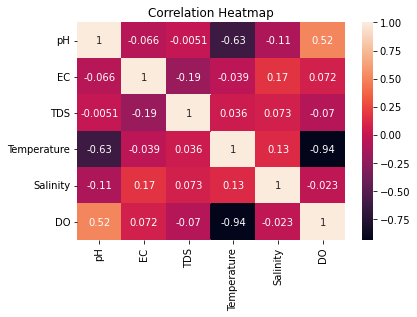

In [10]:
sb.heatmap(DN.loc[:,['pH','EC','TDS','Temperature','Salinity','DO']].corr(),annot=True)
plt.title('Correlation Heatmap')
plt.show()

It is observed that pH and temperature have moderately strong negative correlation. It is common knowledge that when water temperature rises, the pH value falls. Dissolved Oxygen DO and temperature also have a strong negative correlation. As water temperature rises, oxygen and other dissolved gases are expelled.

#Min-max scaling

Min-max scaling is part of the data preprocessing step for principal cpomponent analysis, variables with higher variance, unless normalized, will dominate the components and thus distort the final results.

In [11]:
DX=DN.loc[:,['pH','EC','TDS','Temperature','Salinity','DO']]
DX=(DX-DX.min())/(DX.max()-DX.min())

#Principal Component Analysis

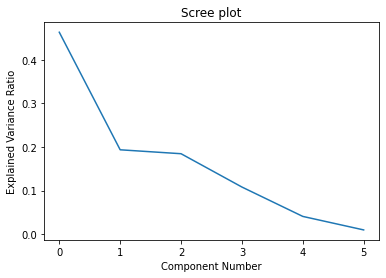

In [12]:
M=PCA(n_components=6)
M.fit(DX)
plt.plot(M.explained_variance_ratio_)
plt.title('Scree plot')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Component Number')
plt.show()

In [13]:
M.explained_variance_ratio_

array([0.46298132, 0.193549  , 0.18454458, 0.108182  , 0.0408537 ,
       0.0098894 ])

As three components can explain 84% of the variance, the rest are discarded.

In [14]:
M=PCA(n_components=3)
M.fit(DX)

PCA(n_components=3)

In [15]:
ND=pd.DataFrame(M.components_,index=['PC1','PC2','PC3'],columns=DX.columns)
ND

,pH,EC,TDS,Temperature,Salinity,DO
PC1,0.227409,0.038708,-0.060137,-0.631524,-0.070828,0.734392
PC2,-0.078486,0.597382,-0.573308,0.058482,0.549956,0.049202
PC3,-0.000076,0.005670,0.694417,-0.029872,0.712001,0.099570


Projecting the data on principal components followed by min-max scaling.

In [16]:
MD=pd.DataFrame( M.transform(DX), columns=['PC1','PC2','PC3'], index=DX.index)
MD=(MD-MD.min())/(MD.max()-MD.min())

#Clustering using DBSCAN

Density Based Clustering technique DBSCAN  is able to find clusters with irregular shape, something that distance based techniques cannot. For the same reasons, it has been used in this scenario. The choice of eps is arbritary. It gives three clusters. 

In [17]:
K1= DBSCAN(eps=0.4, min_samples=2).fit(MD[['PC1','PC2','PC3']])
MD.loc[:,'K1']=K1.labels_
MD.loc[:,'Lat']=DN.Lat
MD.loc[:,'Lon']=DN.Lon

In [18]:
MD.K1.value_counts()

2    18
0     6
1     2
Name: K1, dtype: int64

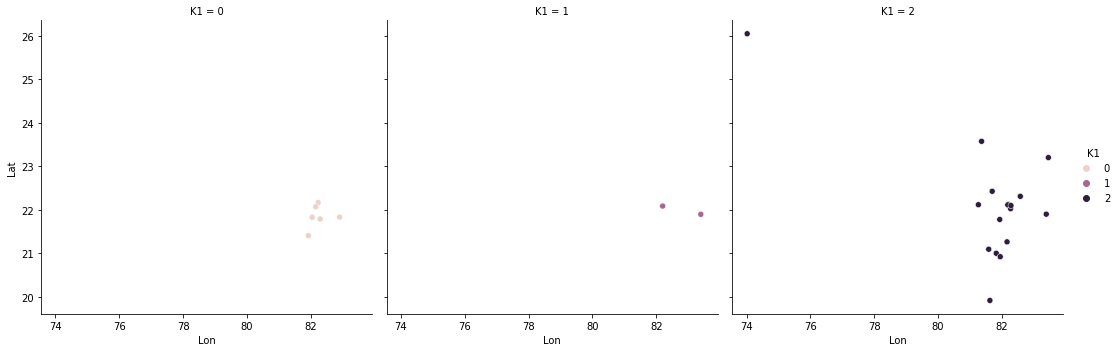

In [19]:
sb.relplot(data=MD, x="Lon", y="Lat",kind="scatter",col='K1',hue='K1')
plt.show()

In [20]:
MD[['K1','PC1','PC2','PC3']].groupby('K1').mean()

,PC1,PC2,PC3
K1,,,
0,0.794295,0.290760,0.378449
1,0.647443,0.959456,0.464351
2,0.138565,0.430071,0.451599


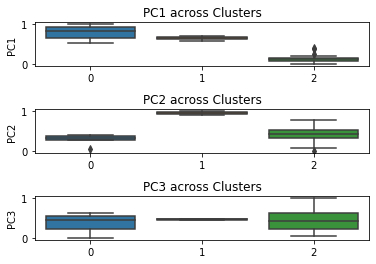

In [21]:
plt.subplot(3,1,1)
sb.boxplot(data=MD,y='PC1',x='K1')
plt.xlabel('')
plt.title('PC1 across Clusters')
plt.subplot(3,1,2)
sb.boxplot(data=MD,y='PC2',x='K1')
plt.title('PC2 across Clusters')
plt.xlabel('')
plt.subplot(3,1,3)
sb.boxplot(data=MD,y='PC3',x='K1')
plt.title('PC3 across Clusters')
plt.xlabel('')
plt.subplots_adjust(hspace=1)
plt.show()